In [1]:
!pip install roboflow
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/detectron2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 93.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.6 MB/s eta 0:00:00
   

In [2]:
import torch
import torchvision
import numpy as np
import json
import os
from roboflow import Roboflow
import matplotlib.pyplot as plt
import shutil
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader,DatasetMapper, build_detection_train_loader
import cv2
from detectron2.utils.events import EventStorage, CommonMetricPrinter, JSONWriter, TensorboardXWriter
from detectron2.modeling import build_model
from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog
import detectron2.utils.comm as comm
import datetime
import math
from math import nan
import time
from detectron2.checkpoint import DetectionCheckpointer

In [3]:
rf = Roboflow(api_key="DBMLp31pkUwD7UVq54eT")
project = rf.workspace("marketshelfdetection").project("pocky-y0ywe")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to pocky-1 in coco:: 100%|██████████| 58/58 [00:00<00:00, 3327.17it/s]


In [4]:
def load_coco_json(file_path):
    """Loads a COCO JSON file and returns a Python dictionary."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None

In [5]:
coco_data = load_coco_json('/content/pocky-1/valid/_annotations.coco.json')

ids = []
labels = []
if coco_data:
    print(type(coco_data))
    categories = coco_data['categories']


    for category in categories:
      ids.append(category['id'])
      labels.append(category['name'])

    labels[0] = "background"
    obtained_dictionary = dict(zip(labels, ids))
    obtained_dictionary_2 = dict(zip(ids, labels))

    label_count = len(labels)

<class 'dict'>


In [6]:
DATA_DIR = '/content/pocky-1'
os.makedirs(os.path.join(DATA_DIR, 'train_annotation'))
shutil.move(os.path.join(DATA_DIR, 'train/_annotations.coco.json'), os.path.join(DATA_DIR, 'train_annotation'))
TRAIN_ANNOTATION_FILE = os.path.join(DATA_DIR, 'train_annotation/_annotations.coco.json')
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'train')
os.makedirs(os.path.join(DATA_DIR, 'val_annotation'))
shutil.move(os.path.join(DATA_DIR, 'valid/_annotations.coco.json'), os.path.join(DATA_DIR, 'val_annotation'))
VAL_ANNOTATION_FILE = os.path.join(DATA_DIR, 'val_annotation/_annotations.coco.json')
VAL_IMAGE_DIR = os.path.join(DATA_DIR, 'valid')
os.makedirs(os.path.join(DATA_DIR, 'test_annotation'))
shutil.move(os.path.join(DATA_DIR, 'test/_annotations.coco.json'), os.path.join(DATA_DIR, 'test_annotation'))
TEST_ANNOTATION_FILE = os.path.join(DATA_DIR, 'test_annotation/_annotations.coco.json')
TEST_IMAGE_DIR = os.path.join(DATA_DIR, 'test')
NUM_CLASSES = label_count
BATCH_SIZE = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
register_coco_instances("my_dataset_train", {}, TRAIN_ANNOTATION_FILE, TRAIN_IMAGE_DIR)
register_coco_instances("my_dataset_val", {}, VAL_ANNOTATION_FILE, VAL_IMAGE_DIR)

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # pretrained weights
cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
cfg.MODEL.RETINANET.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = "./output"
cfg.SOLVER.MAX_ITER = 3000 #40 training images / batch size of 4 * 300 epochs
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [9]:
class LossHook(HookBase):
    def __init__(self, cfg, is_validation=False):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = self.cfg.DATASETS.TEST if is_validation else self.cfg.DATASETS.TRAIN
        self._loader = iter(build_detection_train_loader(self.cfg))
        self.loss_prefix = "val_" if is_validation else "train_"
        self.total_images = 40
        self.total_loss = 0
        self.total_batches=0
        self.patience=5
        self.no_improvements = 0
        self.best_val_loss = float('inf')
        self.is_validation = is_validation
        self.prev_epoch = 0
        self.prev_loss = 0
        self.iter_count = 0
        self.iters_per_epoch = self.total_images // self.cfg.SOLVER.IMS_PER_BATCH
        self.warmup_epoch = self.cfg.SOLVER.WARMUP_ITERS/self.iters_per_epoch

    def after_step(self):
        if self.trainer.iter <= self.cfg.SOLVER.WARMUP_ITERS:
            return
        else:
            data = next(self._loader)
            with torch.no_grad():
                loss_dict = self.trainer.model(data)
                losses = sum(loss_dict.values())
                assert torch.isfinite(losses).all(), loss_dict
                loss_dict_reduced = {self.loss_prefix + k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
                losses_reduced = sum(loss for loss in loss_dict_reduced.values())
                self.total_loss += losses_reduced
                self.total_batches += 1
                self.iter_count += 1

            if self.total_batches>0 and comm.is_main_process() and self.iter_count==self.iters_per_epoch:
                epoch = math.ceil(self.trainer.iter / self.iters_per_epoch)
                average_loss = self.total_loss / self.total_batches

                if self.prev_epoch!= epoch:
                  self.prev_epoch = epoch
                  self.prev_loss = average_loss
                  print(f"{self.loss_prefix.capitalize()}Loss (Epoch {int(self.prev_epoch - self.warmup_epoch)}): {self.prev_loss:.4f}")

                if self.is_validation:
                    if average_loss < self.best_val_loss:
                        self.best_val_loss = average_loss
                        self.no_improvements = 0
                    else:
                        self.no_improvements += 1

                    if self.no_improvements >= self.patience:
                        checkpointer = DetectionCheckpointer(self.trainer.model, save_dir=self.cfg.OUTPUT_DIR)
                        checkpointer.save("RetinaNetwResNet101_Biscuits")
                        raise StopIteration("Early Stopping Trigerred")

                self.total_loss = 0
                self.total_batches=0
                self.iter_count=0
            else:
                return

In [10]:
trainer = DefaultTrainer(cfg)
val_loss_hook = LossHook(cfg, is_validation=True)
trainer.register_hooks([val_loss_hook])
trainer.resume_or_load(resume=False)
trainer.train()

[07/25 07:14:04 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_971ab9.pkl: 228MB [00:01, 146MB/s]                           
head.cls_score.{bias, weight}
  pixel_mean
  pixel_std


[07/25 07:14:06 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


[07/25 07:14:13 d2.utils.events]:  eta: 0:07:42  iter: 19  total_loss: 2.164  loss_cls: 1.765  loss_box_reg: 0.3992    time: 0.2065  last_time: 0.1469  data_time: 0.0171  last_data_time: 0.0076   lr: 0.00019981  max_mem: 7387M
[07/25 07:14:20 d2.utils.events]:  eta: 0:07:30  iter: 39  total_loss: 1.369  loss_cls: 1.154  loss_box_reg: 0.2309    time: 0.1774  last_time: 0.1525  data_time: 0.0073  last_data_time: 0.0069   lr: 0.00039961  max_mem: 7387M
[07/25 07:14:23 d2.utils.events]:  eta: 0:07:28  iter: 59  total_loss: 1.271  loss_cls: 1.077  loss_box_reg: 0.1962    time: 0.1689  last_time: 0.1769  data_time: 0.0076  last_data_time: 0.0100   lr: 0.00059941  max_mem: 7387M
[07/25 07:14:26 d2.utils.events]:  eta: 0:07:24  iter: 79  total_loss: 1.18  loss_cls: 1  loss_box_reg: 0.1819    time: 0.1629  last_time: 0.1569  data_time: 0.0070  last_data_time: 0.0074   lr: 0.00079921  max_mem: 7387M
[07/25 07:14:29 d2.utils.events]:  eta: 0:07:20  iter: 99  total_loss: 1.061  loss_cls: 0.8817  l

StopIteration: Early Stopping Trigerred

Using Checkpoint after Early Stop

In [11]:
model = build_model(cfg)
DetectionCheckpointer(model).load('/content/output/RetinaNetwResNet101_Biscuits.pth')

[07/25 07:17:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/RetinaNetwResNet101_Biscuits.pth ...


{}

In [12]:
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
results=inference_on_dataset(model, val_loader, evaluator)

WARNING [07/25 07:17:11 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [07/25 07:17:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/25 07:17:11 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/pocky-1/val_annotation/_annotations.coco.json
[07/25 07:17:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/25 07:17:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/25 07:17:11 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[07/25 07:17:11 d2.data.common]: Serialized dataset takes 0.01 MiB
[07/25 07:17:11 d2.evaluation.evaluator]: Start inference on 5 batches
[07/25 07:17:11 d2.eval

In [13]:
print(results)

OrderedDict([('bbox', {'AP': 52.67992758344856, 'AP50': 67.8349464159899, 'AP75': 60.37000248981559, 'APs': 7.5, 'APm': 51.98192721057819, 'APl': 85.44004400440043, 'AP-products-3fn9': nan, 'AP-apetito_bbq': 85.54455445544555, 'AP-apetito_pizza': 77.36798679867988, 'AP-apetito_sour_cream': 81.0891089108911, 'AP-astor_1': 45.445544554455445, 'AP-astor_2': 62.42574257425743, 'AP-bar_bar_share': nan, 'AP-bengbeng_chocolate': nan, 'AP-biskies_black_chocolate_creme': nan, 'AP-biskies_chocolate_creme': nan, 'AP-biskuat_chocolate': nan, 'AP-biskuat_vanilla': nan, 'AP-chacha_milk': nan, 'AP-chacha_peanut': nan, 'AP-choco_pie': 0.0, 'AP-chocolatos_delight_chocolate': 73.24257425742574, 'AP-chocolatos_delight_vanilla': 100.0, 'AP-chocolito_original': nan, 'AP-chocolito_rich_choco': nan, 'AP-chocopie': nan, 'AP-chocopie_small': 10.099009900990099, 'AP-chocopie_strawberry': 69.80198019801979, 'AP-custas': 71.94719471947194, 'AP-dilan_sandwich': nan, 'AP-dilan_waffle': nan, 'AP-genji_original': nan

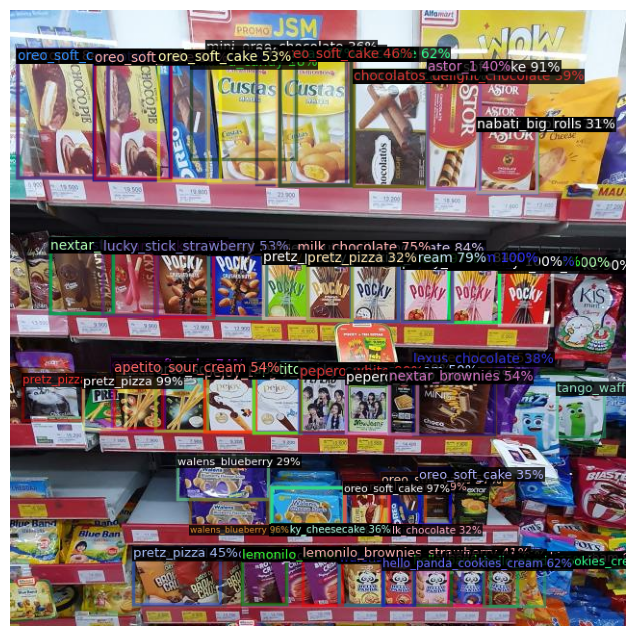

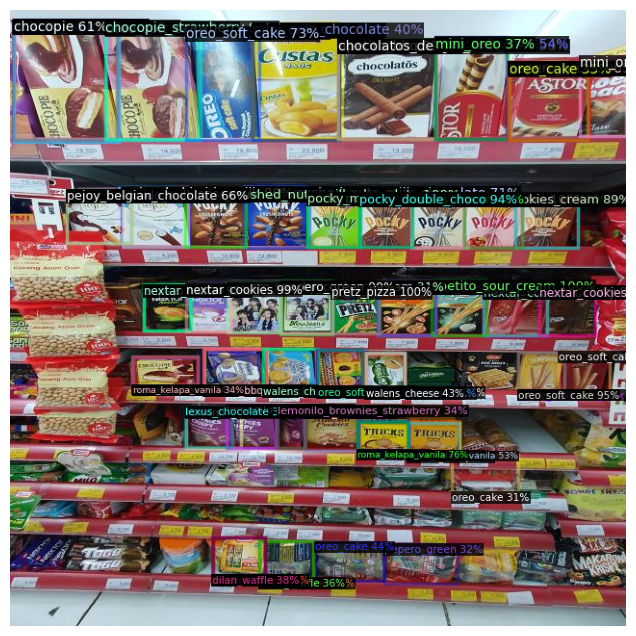

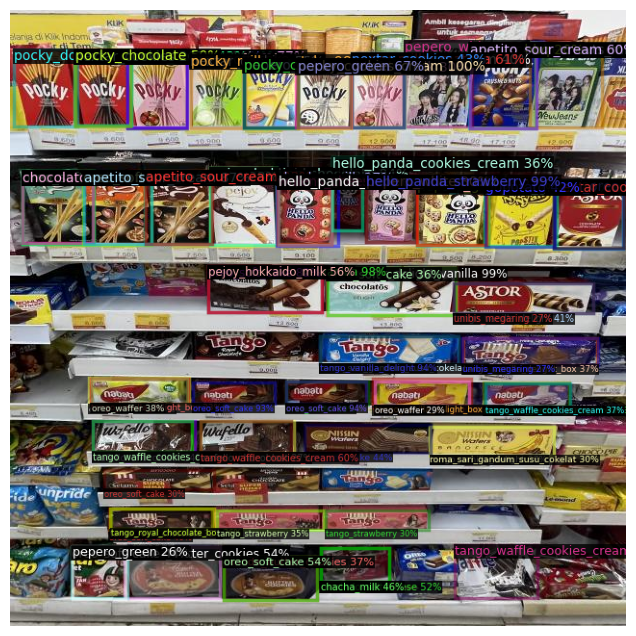

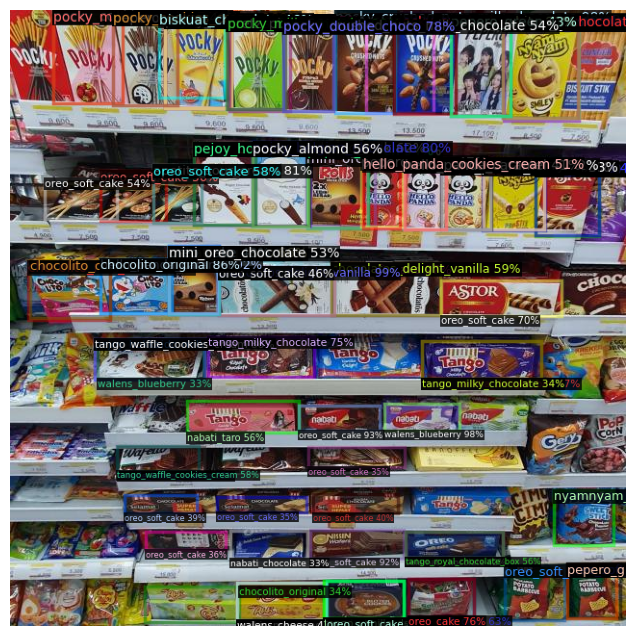

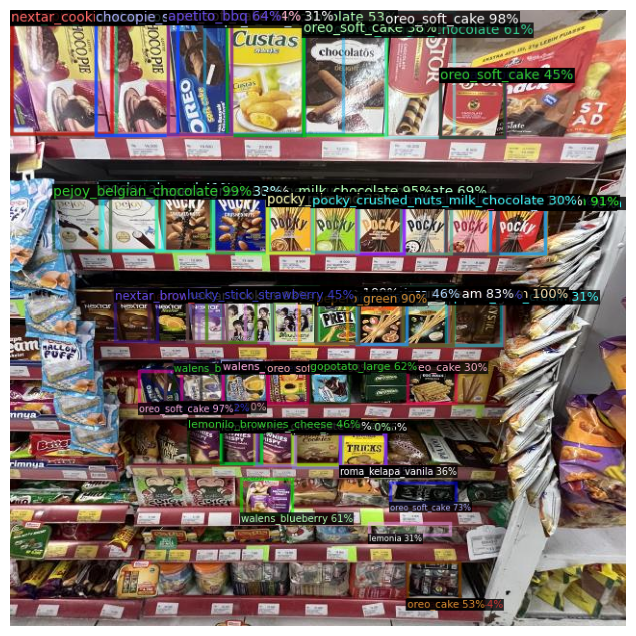

In [14]:
images = os.listdir(TEST_IMAGE_DIR)
for imageName in images:
  image = cv2.imread(os.path.join(TEST_IMAGE_DIR, imageName))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  height, width = image.shape[:2]
  inputs = [{"image": torch.as_tensor(image.transpose(2, 0, 1)).float().to("cuda"), "height": height, "width": width}]

# Run inference
  model.eval()
  with torch.no_grad():
      outputs = model(inputs)[0]  # returns list of outputs

# Access outputs
  instances = outputs["instances"].to("cpu")
  plt.figure(figsize=(12, 8))
  v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
  out = v.draw_instance_predictions(instances)
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.axis("off")
  plt.show()

In [15]:
from google.colab import files
files.download("/content/output/RetinaNetwResNet101_Biscuits.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>